In [1]:
# General and Data Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Data Balancing
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
# Load metadata
data = pd.read_csv('/kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv')

# Check image folder structure
dataset_path = '/kaggle/input/isic-2019-skin-lesion-images-for-classification/'

In [4]:
# Function to Load and Resize Images
def load_and_resize_images(image_paths, target_size=(28, 28)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

# Define classes
class_folders = ['MEL', 'VASC', 'SCC', 'DF', 'NV', 'BKL', 'BCC', 'AK']

In [5]:
# Load images and labels
all_images, all_labels = [], []

for class_name in class_folders:
    class_folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_folder_path)
    class_images = load_and_resize_images([os.path.join(class_folder_path, img) for img in image_files])
    all_images.append(class_images)
    all_labels.append([class_name] * len(image_files))

# Combine all data
X_all = np.concatenate(all_images, axis=0)
y_all = np.concatenate(all_labels, axis=0)

In [6]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)

# Reshape data for oversampling
X_reshaped = X_all.reshape(X_all.shape[0], -1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_one_hot)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reshape back to image format
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 3)

In [7]:
# ViT Parameters
img_size = 28  # Image size (28x28)
patch_size = 4  # Patch size
num_classes = len(class_folders)
projection_dim = 64
num_heads = 4
transformer_layers = 8
mlp_head_units = [256, 128]

In [8]:
# ViT Patch and Embedding Layer
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=patch.shape[1], delta=1)
        return self.projection(patch) + self.position_embedding(positions)


In [9]:
# ViT Model
def build_vit_classifier():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    num_patches = (img_size // patch_size) ** 2

    # Convert images to patches using a Lambda layer
    def extract_patches_fn(images):
        return tf.image.extract_patches(
            images=images,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

    patches = layers.Lambda(extract_patches_fn)(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)
    embedded_patches = PatchEmbedding(num_patches, projection_dim)(patches)

    # Transformer Encoder
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization()(embedded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, embedded_patches])
        x3 = layers.LayerNormalization()(x2)
        x3 = keras.Sequential([
            layers.Dense(projection_dim * 2, activation="relu"),
            layers.Dense(projection_dim)
        ])(x3)
        embedded_patches = layers.Add()([x3, x2])

    x = layers.LayerNormalization()(embedded_patches)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)

    # MLP Head
    for units in mlp_head_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

In [10]:
# Compile and Train Model
vit_model = build_vit_classifier()
vit_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = vit_model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=100, batch_size=64, callbacks=callbacks)

Epoch 1/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.1391 - loss: 2.1147 - val_accuracy: 0.2973 - val_loss: 1.8205 - learning_rate: 0.0010
Epoch 2/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.2999 - loss: 1.7844 - val_accuracy: 0.3674 - val_loss: 1.5876 - learning_rate: 0.0010
Epoch 3/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.3771 - loss: 1.5804 - val_accuracy: 0.4268 - val_loss: 1.4716 - learning_rate: 0.0010
Epoch 4/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4071 - loss: 1.5004 - val_accuracy: 0.4514 - val_loss: 1.3901 - learning_rate: 0.0010
Epoch 5/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4335 - loss: 1.4364 - val_accuracy: 0.4687 - val_loss: 1.3335 - learning_rate: 0.0010
Epoch 6/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4558 - loss: 1.3831 - val_accuracy: 0.5015 - val_loss: 1.2713 - learning_rate: 0.0010
Epoch 7/100
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step -

644/644 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8958 - loss: 0.2991
Test Accuracy: 89.83%
Test Loss: 0.3043
644/644 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
              precision    recall  f1-score   support

          AK       0.99      1.00      0.99      2582
         BCC       0.86      0.95      0.90      2665
         BKL       0.81      0.89      0.85      2582
          DF       1.00      1.00      1.00      2517
         MEL       0.80      0.70      0.75      2612
          NV       0.72      0.65      0.68      2557
         SCC       0.99      1.00      0.99      2550
        VASC       1.00      1.00      1.00      2535

    accuracy                           0.90     20600
   macro avg       0.90      0.90      0.90     20600
weighted avg       0.90      0.90      0.90     20600



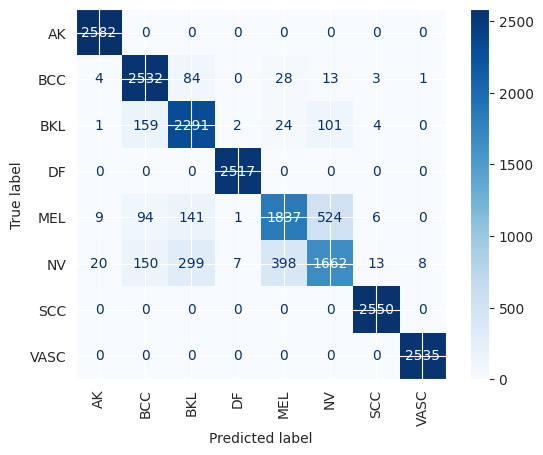

In [11]:
# Evaluate Model
test_loss, test_accuracy = vit_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Predictions and Confusion Matrix
y_pred = np.argmax(vit_model.predict(X_test_reshaped), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

In [12]:
# Save Model
vit_model.save("/kaggle/working/ViT_Model.h5")